Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.6393
Epoch [2/10], Loss: 1.4523
Epoch [3/10], Loss: 1.3688
Epoch [4/10], Loss: 1.3084
Epoch [5/10], Loss: 1.2556
Epoch [6/10], Loss: 1.2173
Epoch [7/10], Loss: 1.1764
Epoch [8/10], Loss: 1.1376
Epoch [9/10], Loss: 1.1022
Epoch [10/10], Loss: 1.0735
Epoch [1/10], Loss: 1.3516
Epoch [2/10], Loss: 1.3140
Epoch [3/10], Loss: 1.2987
Epoch [4/10], Loss: 1.2854
Epoch [5/10], Loss: 1.2709
Epoch [6/10], Loss: 1.2538
Epoch [7/10], Loss: 1.2461
Epoch [8/10], Loss: 1.2281
Epoch [9/10], Loss: 1.2194
Epoch [10/10], Loss: 1.2096
Epoch [1/10], Loss: 0.8978
Epoch [2/10], Loss: 0.8761
Epoch [3/10], Loss: 0.8573
Epoch [4/10], Loss: 0.8339
Epoch [5/10], Loss: 0.8174
Epoch [6/10], Loss: 0.7933
Epoch [7/10], Loss: 0.7784
Epoch [8/10], Loss: 0.7687
Epoch [9/10], Loss: 0.7526
Epoch [10/10], Loss: 0.7364


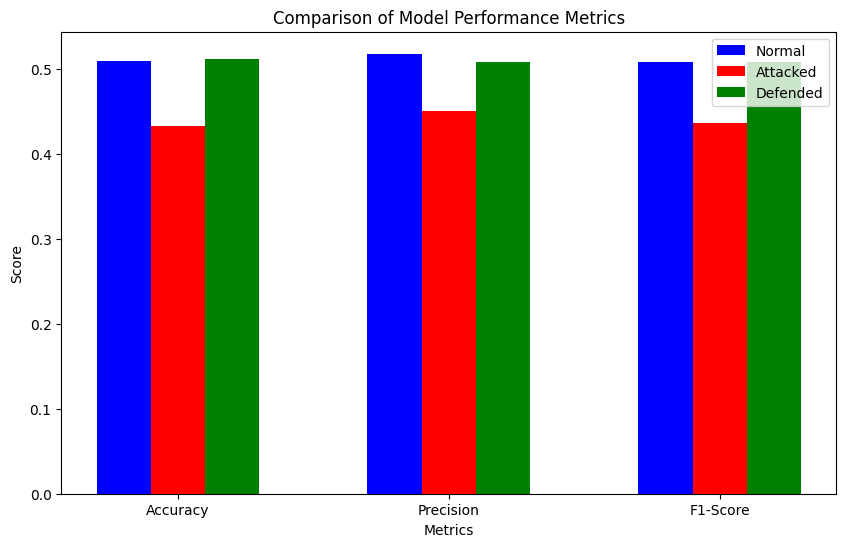

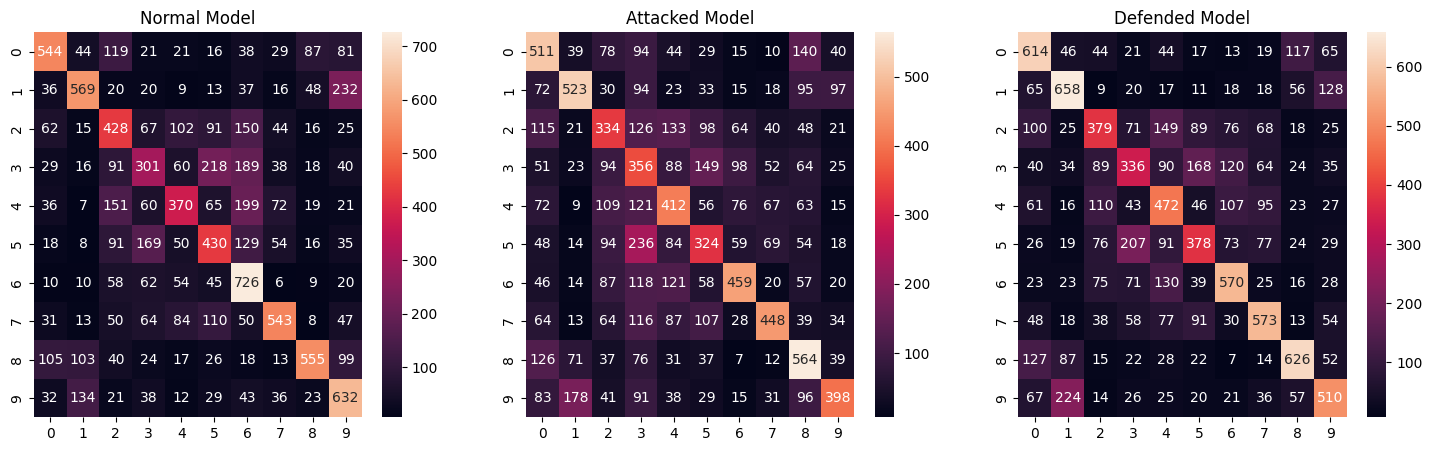

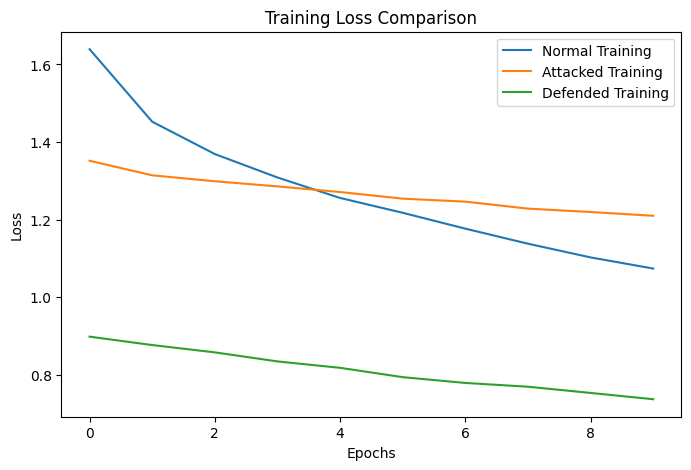

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
    train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    return train_loader, test_loader

# Define Simple Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Randomized Smoothing Function
class RandomizedSmoothing:
    def __init__(self, base_model, noise_std=0.25, num_samples=100):
        self.base_model = base_model
        self.noise_std = noise_std
        self.num_samples = num_samples

    def predict(self, x):
        self.base_model.eval()
        with torch.no_grad():
            batch_size = x.size(0)
            votes = torch.zeros((batch_size, 10)).to(device)
            for _ in range(self.num_samples):
                noisy_x = x + torch.randn_like(x) * self.noise_std
                outputs = self.base_model(noisy_x)
                votes += torch.softmax(outputs, dim=1)
            return torch.argmax(votes, dim=1)

# Train Model
train_losses, attack_losses, defense_losses = [], [], []
def train_model(model, train_loader, criterion, optimizer, epochs=10, attack=False, defense=False):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Apply attack if in attack mode
            if attack:
                corrupt_count = int(images.size(0) * 0.2)  # Corrupt 20% of the batch
                corrupt_indices = np.random.choice(images.size(0), corrupt_count, replace=False)
                images[corrupt_indices] = torch.rand_like(images[corrupt_indices])

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        if attack:
            attack_losses.append(avg_loss)
        elif defense:
            defense_losses.append(avg_loss)
        else:
            train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Test Model
def test_model(model, test_loader, smoothing=None):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            if smoothing:
                predicted = smoothing.predict(images)
            else:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return y_true, y_pred

# Query Injection Attack Implementation
def query_injection_attack(model, test_loader, injection_rate=0.1):
    """
    Simulates a query injection attack by randomly corrupting a percentage of the test set.
    injection_rate: Percentage of the test set to corrupt.
    """
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            batch_size = images.size(0)
            corrupt_count = int(batch_size * injection_rate)
            corrupt_indices = np.random.choice(batch_size, corrupt_count, replace=False)

            # Corrupt selected images by randomizing their pixel values
            corrupted_images = images.clone()
            corrupted_images[corrupt_indices] = torch.rand_like(corrupted_images[corrupt_indices])

            outputs = model(corrupted_images.to(device))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return y_true, y_pred

# Load data
train_loader, test_loader = load_data()

# Initialize and train normal model
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, criterion, optimizer)
y_true, y_pred_normal = test_model(model, test_loader)

# Apply Query Injection Attack Training
train_model(model, train_loader, criterion, optimizer, attack=True)

# Defend with Randomized Smoothing Training
train_model(model, train_loader, criterion, optimizer, defense=True)

# Apply Query Injection Attack
y_true, y_pred_attacked = query_injection_attack(model, test_loader, injection_rate=0.2)

# Defend with Randomized Smoothing
smoothing = RandomizedSmoothing(model, noise_std=0.25, num_samples=100)
y_true, y_pred_defended = test_model(model, test_loader, smoothing=smoothing)

# Evaluation Metrics
accuracy_normal = accuracy_score(y_true, y_pred_normal)
accuracy_attacked = accuracy_score(y_true, y_pred_attacked)
accuracy_defended = accuracy_score(y_true, y_pred_defended)

precision_normal = precision_score(y_true, y_pred_normal, average='macro')
precision_attacked = precision_score(y_true, y_pred_attacked, average='macro')
precision_defended = precision_score(y_true, y_pred_defended, average='macro')

f1_normal = f1_score(y_true, y_pred_normal, average='macro')
f1_attacked = f1_score(y_true, y_pred_attacked, average='macro')
f1_defended = f1_score(y_true, y_pred_defended, average='macro')

# Bar Chart for Metrics Comparison
metrics = ['Accuracy', 'Precision', 'F1-Score']
norm_values = [accuracy_normal, precision_normal, f1_normal]
attack_values = [accuracy_attacked, precision_attacked, f1_attacked]
defense_values = [accuracy_defended, precision_defended, f1_defended]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, norm_values, width, label='Normal', color='blue')
rects2 = ax.bar(x, attack_values, width, label='Attacked', color='red')
rects3 = ax.bar(x + width, defense_values, width, label='Defended', color='green')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

# Confusion Matrices
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_true, y_pred_normal), annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Normal Model')
sns.heatmap(confusion_matrix(y_true, y_pred_attacked), annot=True, fmt='d', ax=ax[1])
ax[1].set_title('Attacked Model')
sns.heatmap(confusion_matrix(y_true, y_pred_defended), annot=True, fmt='d', ax=ax[2])
ax[2].set_title('Defended Model')
plt.show()

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Normal Training')
plt.plot(attack_losses, label='Attacked Training')
plt.plot(defense_losses, label='Defended Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
